In [2]:
# Import dependencies 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import multihash as mh
import hashlib as hl
from cid import make_cid
from math import log2
import psycopg2

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (12, 8)

db_con = psycopg2.connect(
    host="localhost",
    port="5433",
    database="hoarder_test",
    user="hoarder",
    password="password")

In [3]:
def get_in_degree(org, new) -> int:
    in_degree = 0
    for new_peer in new:
        if new_peer in org:
            in_degree += 1
    return in_degree

def hash_int_from_peer_id(peer_id: str) -> int:
    multihash = mh.from_b58_string(peer_id)
    hash_b = hl.sha256(multihash).digest()
    return int.from_bytes(hash_b, byteorder='big')

def hash_int_from_cid(cid: str) -> int:
    cid = make_cid(cid)
    cid_hash = hl.sha256(cid.multihash).digest()
    return int.from_bytes(cid_hash, byteorder='big')


def get_xor_distance(base: int, comp: int) -> int:
    return abs(base ^ comp)

In [4]:
ping_rounds = pd.read_sql_query("""select ping_round from fetch_results group by ping_round order by ping_round ASC;""", db_con)

In [5]:
# Get PR Holders for each CID
pr_holders = pd.read_sql_query("""select cid_hash, peer_id from pr_holders""", db_con)

init_holders = {}
for i, r in pr_holders.iterrows():
    if r['cid_hash'] not in init_holders:
        init_holders[r['cid_hash']] = []
    init_holders[r['cid_hash']].append(r['peer_id'])
    
in_degree_dist = []

init_in_degree = []
for cid in init_holders:
    in_d = get_in_degree(init_holders[cid], init_holders[cid])
    init_in_degree.append(in_d)

in_degree_dist.append(init_in_degree)


for i, r in ping_rounds.iterrows():
    if r['ping_round'] == 0: # first round has no closest peers
        continue
        
    print(f"round {r['ping_round']}/{len(ping_rounds)}")
    round_close_peers = {}
    close_peers = pd.read_sql_query(f"""
    select cid_hash, peer_id from k_closest_peers where ping_round={r['ping_round']} order by cid_hash
    """, db_con)
    
    for i, r in close_peers.iterrows():
        if r['cid_hash'] not in round_close_peers:
            round_close_peers[r['cid_hash']] = []
        round_close_peers[r['cid_hash']].append(r['peer_id'])
        
    round_close_p_dist = []
    for c in init_holders:
        try:
            in_d = get_in_degree(init_holders[cid], round_close_peers[cid])
            round_close_p_dist.append(in_d)
        except:
            round_close_p_dist.append(0)
            
    in_degree_dist.append(round_close_p_dist)



round 1/11
round 2/11
round 3/11
round 4/11
round 5/11
round 6/11
round 7/11
round 8/11
round 9/11
round 10/11


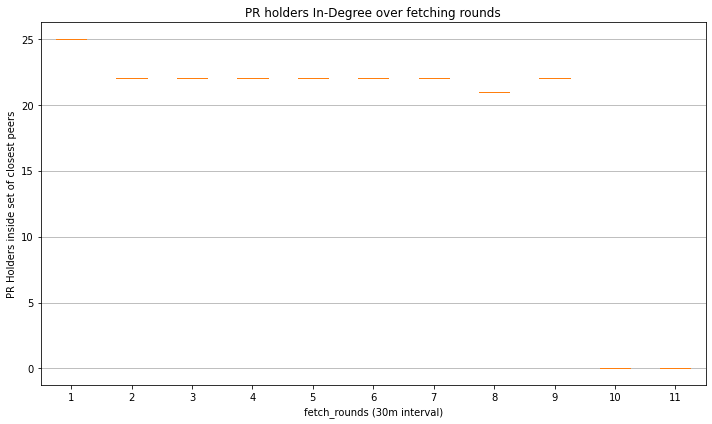

In [6]:
# Display the distribution
fig, ax = plt.subplots()
ax.boxplot(in_degree_dist, showfliers=True) 
ax.set_xlabel("fetch_rounds (30m interval)") # TODO: hardcoded to 30 mins
ax.set_ylabel("PR Holders inside set of closest peers")
ax.figure.set_size_inches(10, 6)
plt.title(f"PR holders In-Degree over fetching rounds")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [7]:
# Compare the distance between a random CID and the PR Holders vs K Closest Peers
c = pd.read_sql_query("select cid_hash from cid_info where id=2", db_con)
CID = c['cid_hash'][0]
cid_hash_int = hash_int_from_cid(CID)

# Get the peer_id sets for a single CID (PR Holders and Kclosest peers of the first round)
pr_holders = pd.read_sql_query(f"select peer_id from pr_holders where cid_hash='{CID}';", db_con)
tot_peers = pd.read_sql_query(f"select peer_id from peer_info;", db_con)


# Get the hash value and hash_int of each of the sets
pr_holders['xor_dist'] = pr_holders.apply(lambda row: get_xor_distance(cid_hash_int, hash_int_from_peer_id(row['peer_id'])) , axis=1)
pr_holders['xor_dist_log2'] = pr_holders.apply(lambda row: log2(row['xor_dist']), axis=1)
pr_holders['xor_dist_normed'] = pr_holders['xor_dist'] / (2**256 - 1) * 100


tot_peers['xor_dist'] = tot_peers.apply(lambda row: get_xor_distance(cid_hash_int, hash_int_from_peer_id(row['peer_id'])) , axis=1)
tot_peers['xor_dist_log2'] = tot_peers.apply(lambda row: log2(row['xor_dist']), axis=1)
tot_peers['xor_dist_normed'] = tot_peers['xor_dist'] / (2**256 - 1) * 100

pr_holders = pr_holders.sort_values('xor_dist')
tot_peers = tot_peers.sort_values('xor_dist')

ln_tot = np.linspace(0, len(tot_peers), len(tot_peers))
ln_p = np.linspace(0, len(pr_holders), len(pr_holders))


Text(0.5, 1.0, 'CID xor distance with set of peers')

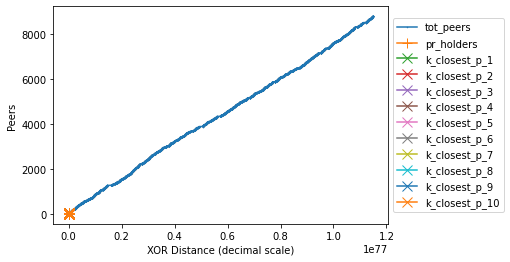

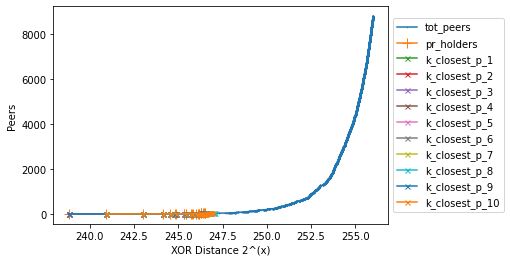

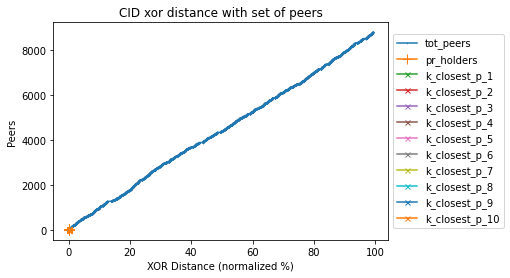

In [8]:
fig_xor, ax_xor = plt.subplots()

ax_xor.plot(tot_peers['xor_dist'], ln_tot, marker='.',  ms=1, label='tot_peers')
ax_xor.plot(pr_holders['xor_dist'], ln_p, marker='+', ms=10.0, label='pr_holders')

fig_xor_log2, ax_xor_log2 = plt.subplots()
ax_xor_log2.plot(tot_peers['xor_dist_log2'], ln_tot, marker='.',  ms=1, label='tot_peers')
ax_xor_log2.plot(pr_holders['xor_dist_log2'], ln_p, marker='+', ms=10.0, label='pr_holders')

fig_xor_normed, ax_xor_normed = plt.subplots()
ax_xor_normed.plot(tot_peers['xor_dist_normed'], ln_tot, marker='.',  ms=1, label='tot_peers')
ax_xor_normed.plot(pr_holders['xor_dist_normed'], ln_p, marker='+', ms=10.0, label='pr_holders')

for i, row in ping_rounds.iterrows():
    if i > 15:
        break
    k_close_p = pd.read_sql_query(f"select peer_id from k_closest_peers where cid_hash='{CID}' and ping_round={row['ping_round']};", db_con)
    if len(k_close_p) == 0:
        continue
    k_close_p['xor_dist'] = k_close_p.apply(lambda row: get_xor_distance(cid_hash_int, hash_int_from_peer_id(row['peer_id'])), axis=1)
    k_close_p['xor_dist_log2'] = k_close_p.apply(lambda row: log2(row['xor_dist']), axis=1)
    k_close_p['xor_dist_normed'] = k_close_p['xor_dist'] / (2**256 - 1) * 100
    
    ln_p = np.linspace(0, len(k_close_p), len(k_close_p))
    ax_xor.plot(k_close_p['xor_dist'], ln_p, marker='x', ms=10.0, label=f"k_closest_p_{row['ping_round']}")
    ax_xor_log2.plot(k_close_p['xor_dist_log2'], ln_p, marker='x', ms=5.0, label=f"k_closest_p_{row['ping_round']}")
    ax_xor_normed.plot(k_close_p['xor_dist_normed'], ln_p, marker='x', ms=5.0, label=f"k_closest_p_{row['ping_round']}")

ax_xor.set_xlabel('XOR Distance (decimal scale)')
ax_xor.set_ylabel('Peers')
ax_xor.axis('tight')
ax_xor.legend()
ax_xor.legend(loc='center left', bbox_to_anchor=(1, 0.5))


ax_xor_log2.set_xlabel('XOR Distance 2^(x)')
ax_xor_log2.set_ylabel('Peers')
ax_xor_log2.axis('tight')
ax_xor_log2.legend()
ax_xor_log2.legend(loc='center left', bbox_to_anchor=(1, 0.5))


ax_xor_normed.set_xlabel('XOR Distance (normalized %)')
ax_xor_normed.set_ylabel('Peers')
ax_xor_normed.axis('tight')
ax_xor_normed.legend()
ax_xor_normed.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.title('CID xor distance with set of peers')

Text(0.5, 1.0, 'CID xor distance with set of peers')

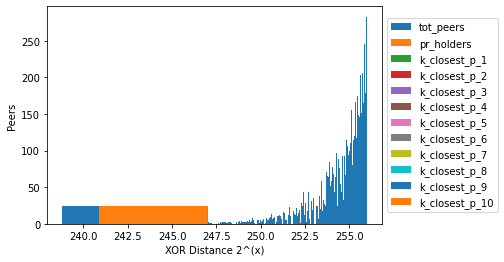

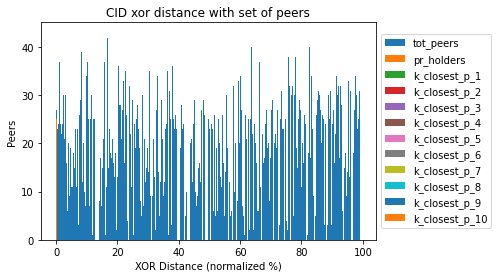

In [9]:
#fig_xor, ax_xor = plt.subplots()

#ax_xor.hist(tot_peers['xor_dist'].to_numpy(dtype=float), bins=200, label='tot_peers')
#ax_xor.hist(pr_holders['xor_dist'].to_numpy(dtype=float), bins=1, label='pr_holders')

fig_xor_log2, ax_xor_log2 = plt.subplots()
ax_xor_log2.hist(tot_peers['xor_dist_log2'].to_numpy(dtype=float), bins=500, label='tot_peers')
ax_xor_log2.hist(pr_holders['xor_dist_log2'].to_numpy(dtype=float), bins=1, label='pr_holders')

fig_xor_normed, ax_xor_normed = plt.subplots()
ax_xor_normed.hist(tot_peers['xor_dist_normed'].to_numpy(dtype=float), bins=500, label='tot_peers')
ax_xor_normed.hist(pr_holders['xor_dist_normed'].to_numpy(dtype=float), bins=1, label='pr_holders')


for i, row in ping_rounds.iterrows():
    if i > 15:
        break
    k_close_p = pd.read_sql_query(f"select peer_id from k_closest_peers where cid_hash='{CID}' and ping_round={row['ping_round']};", db_con)
    if len(k_close_p) == 0:
        continue
    k_close_p['xor_dist'] = k_close_p.apply(lambda row: get_xor_distance(cid_hash_int, hash_int_from_peer_id(row['peer_id'])), axis=1)
    k_close_p['xor_dist_log2'] = k_close_p.apply(lambda row: log2(row['xor_dist']), axis=1)
    k_close_p['xor_dist_normed'] = k_close_p['xor_dist'] / (2**256 - 1) * 100

    #ax_xor.hist(k_close_p['xor_dist'].to_numpy(dtype=float), bins=200, label=f"k_closest_p_{row['ping_round']}")
    ax_xor_log2.hist(k_close_p['xor_dist_log2'].to_numpy(dtype=float), bins=1, label=f"k_closest_p_{row['ping_round']}")
    ax_xor_normed.hist(k_close_p['xor_dist_normed'].to_numpy(dtype=float), bins=1, label=f"k_closest_p_{row['ping_round']}")


ax_xor.set_xlabel('XOR Distance (decimal scale)')
ax_xor.set_ylabel('Peers')
ax_xor.axis('tight')
ax_xor.legend()
ax_xor.legend(loc='center left', bbox_to_anchor=(1, 0.5))


ax_xor_log2.set_xlabel('XOR Distance 2^(x)')
ax_xor_log2.set_ylabel('Peers')
ax_xor_log2.axis('tight')
ax_xor_log2.legend()
ax_xor_log2.legend(loc='center left', bbox_to_anchor=(1, 0.5))


ax_xor_normed.set_xlabel('XOR Distance (normalized %)')
ax_xor_normed.set_ylabel('Peers')
ax_xor_normed.axis('tight')
ax_xor_normed.legend()
ax_xor_normed.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.title('CID xor distance with set of peers')

Analysis of the Normed XOR distance between the CIDs and the PR Holders IDs 
(https://github.com/dennis-tra/optimistic-provide#normed-xor-distance)


0         0.000963
1         0.001372
2          0.00815
3         0.011945
4         0.012196
            ...   
113674    0.108416
113675    0.109181
113676    0.111035
113677    0.120315
113678    0.121984
Name: xor_dist_normed, Length: 113679, dtype: object


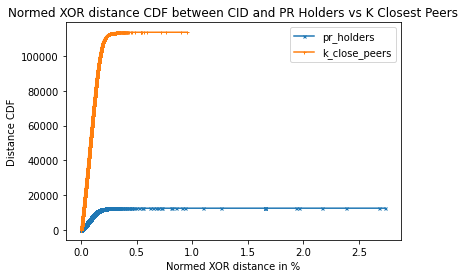

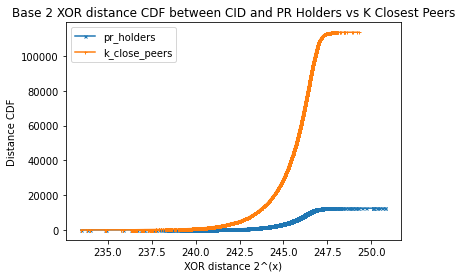

In [10]:

# Get the peer_id sets for a single CID (PR Holders and Kclosest peers of the first round)
pr_holders = pd.read_sql_query(f"select cid_hash, peer_id from pr_holders;", db_con)
k_close_p = pd.read_sql_query(f"select cid_hash, ping_round, peer_id from k_closest_peers limit 500000;", db_con)


# Get the hash value and hash_int of each of the sets
pr_holders['xor_dist'] = pr_holders.apply(lambda row: get_xor_distance(hash_int_from_cid(row['cid_hash']), hash_int_from_peer_id(row['peer_id'])) , axis=1)
pr_holders['xor_dist_log2'] = pr_holders.apply(lambda row: log2(row['xor_dist']), axis=1)
pr_holders['xor_dist_normed'] = pr_holders['xor_dist'] / (2**256 - 1) * 100


k_close_p['xor_dist'] = k_close_p.apply(lambda row: get_xor_distance(hash_int_from_cid(row['cid_hash']), hash_int_from_peer_id(row['peer_id'])), axis=1)
k_close_p['xor_dist_log2'] = k_close_p.apply(lambda row: log2(row['xor_dist']), axis=1)
k_close_p['xor_dist_normed'] = k_close_p['xor_dist'] / (2**256 - 1) * 100

print(k_close_p['xor_dist_normed'])

pr_holders = pr_holders.sort_values('xor_dist')
k_close_p = k_close_p.sort_values('xor_dist')

ln_p = np.linspace(0, len(pr_holders), len(pr_holders))
k_p = np.linspace(0, len(k_close_p), len(k_close_p))

plt.plot(pr_holders['xor_dist_normed'], ln_p, marker='x', ms=3.0, label='pr_holders')
plt.plot(k_close_p['xor_dist_normed'], k_p, marker='+', ms=3.0, label='k_close_peers')
plt.ylabel('Distance CDF')
plt.xlabel('Normed XOR distance in %')
plt.title('Normed XOR distance CDF between CID and PR Holders vs K Closest Peers')
plt.legend()
plt.show()

plt.plot(pr_holders['xor_dist_log2'], ln_p, marker='x', ms=3.0, label='pr_holders')
plt.plot(k_close_p['xor_dist_log2'], k_p, marker='+', ms=3.0, label='k_close_peers')
plt.ylabel('Distance CDF')
plt.xlabel('XOR distance 2^(x)')
plt.title('Base 2 XOR distance CDF between CID and PR Holders vs K Closest Peers')
plt.legend()
plt.show()


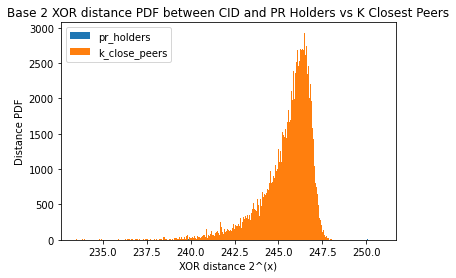

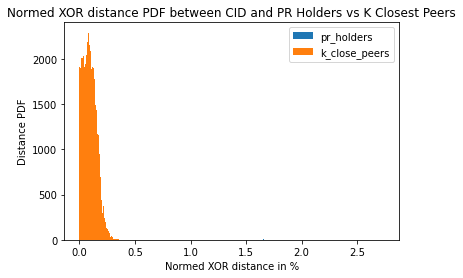

In [11]:

pr_h = np.array(pr_holders['xor_dist_log2'], dtype=float)
k_clos = np.array(k_close_p['xor_dist_log2'], dtype=float)

plt.hist(pr_h, bins=300, label='pr_holders')
plt.hist(k_clos, bins=300, label='k_close_peers')
plt.ylabel('Distance PDF')
plt.xlabel('XOR distance 2^(x)')
plt.title('Base 2 XOR distance PDF between CID and PR Holders vs K Closest Peers')
plt.legend()
plt.show()

pr_h_normed = np.array(pr_holders['xor_dist_normed'], dtype=float)
k_clos_normed = np.array(k_close_p['xor_dist_normed'], dtype=float)

plt.hist(pr_h_normed, bins=300, label='pr_holders')
plt.hist(k_clos_normed, bins=300, label='k_close_peers')
plt.ylabel('Distance PDF')
plt.xlabel('Normed XOR distance in %')
plt.title('Normed XOR distance PDF between CID and PR Holders vs K Closest Peers')
plt.legend()
plt.show()


In [ ]:
db_con.close()